In [62]:
!pip install plotly
!pip install nbformat
!pip install jupyter



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


df_mapping columns: Index(['id', 'name'], dtype='object')
df_real columns: Index(['crate', 'trust_cost', 'distrust_cost', 'severity', 'ratio'], dtype='object')


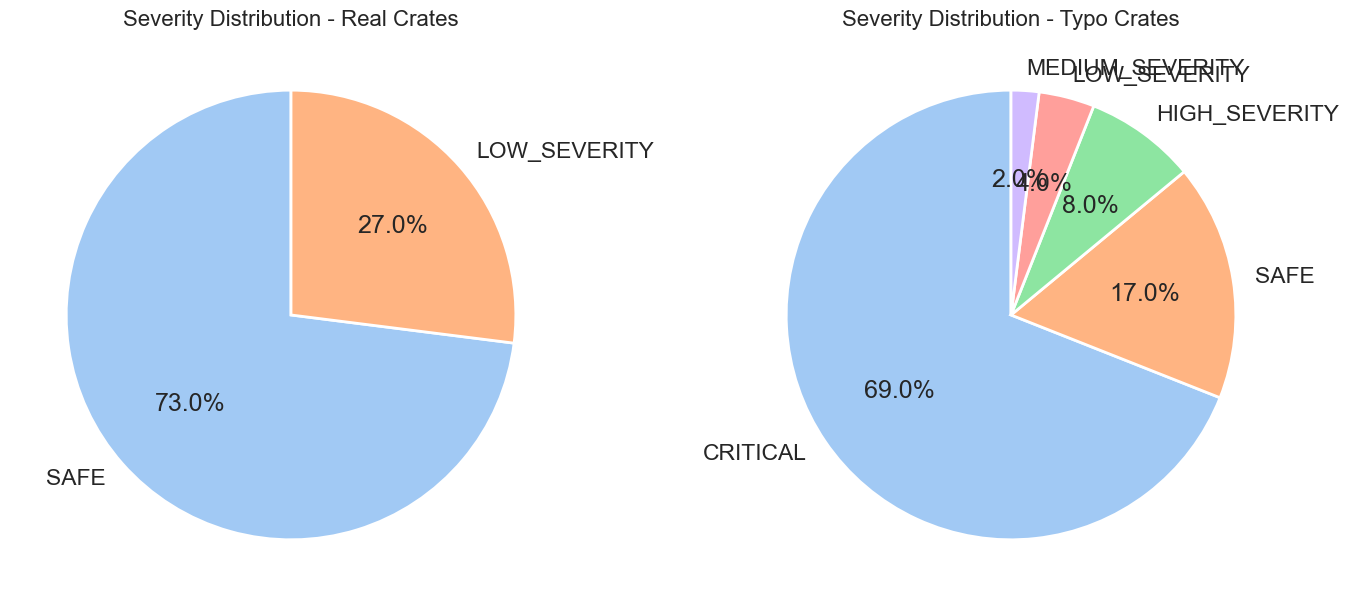

In [63]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set a Seaborn theme for a modern look.
sns.set_theme(style="whitegrid", context="talk")

# Function to parse the evaluation file and extract the metrics.
def parse_evaluation_file(filepath):
    with open(filepath, 'r') as f:
        content = f.read()
    # Extract trust cost (assumes the pattern "Trust Cost ...: <number> cost")
    trust_match = re.search(r"Trust Cost.*:\s*(\d+)\s*cost", content)
    trust_cost = int(trust_match.group(1)) if trust_match else None

    # Extract distrust cost (assumes the pattern "Distrust Cost ...: <number> cost")
    distrust_match = re.search(r"Distrust Cost.*:\s*(\d+)\s*cost", content)
    distrust_cost = int(distrust_match.group(1)) if distrust_match else None

    # Extract severity label (assumes the pattern "Severity Label: <LABEL>")
    severity_match = re.search(r"Severity Label:\s*(\w+)", content)
    severity = severity_match.group(1) if severity_match else None

    # Compute ratio (trust_cost/distrust_cost) if possible.
    ratio = trust_cost / distrust_cost if trust_cost is not None and distrust_cost not in (None, 0) else None

    return trust_cost, distrust_cost, severity, ratio

# --------------------------
# Read data from the real evaluation files
# --------------------------
real_dir = os.path.join("evaluation", "rq1", "real")
real_data = []
for filename in sorted(os.listdir(real_dir)):
    filepath = os.path.join(real_dir, filename)
    trust_cost, distrust_cost, severity, ratio = parse_evaluation_file(filepath)
    crate = os.path.splitext(filename)[0]  # remove extension to get the crate name
    real_data.append({
        "crate": crate,
        "trust_cost": trust_cost,
        "distrust_cost": distrust_cost,
        "severity": severity,
        "ratio": ratio
    })
df_real = pd.DataFrame(real_data)

# --------------------------
# Read data from the typo evaluation files
# --------------------------
typo_dir = os.path.join("evaluation", "rq1", "typo")
typo_data = []
for filename in sorted(os.listdir(typo_dir)):
    filepath = os.path.join(typo_dir, filename)
    trust_cost, distrust_cost, severity, ratio = parse_evaluation_file(filepath)
    typo_data.append({
        "typo": os.path.splitext(filename)[0],  # remove extension
        "trust_cost": trust_cost,
        "distrust_cost": distrust_cost,
        "severity": severity,
        "ratio": ratio
    })
df_typo = pd.DataFrame(typo_data)

# --------------------------
# Read the mapping file top100_crates.csv
# --------------------------
df_mapping = pd.read_csv("top100_crates.csv")  # adjust the path if necessary
print("df_mapping columns:", df_mapping.columns)
print("df_real columns:", df_real.columns)

# --------------------------
# Merge Mapping with Real Data
# --------------------------
# For real crates, we assume that the file name (crate) matches the mapping's id.
df_real = df_mapping.merge(df_real, left_on="id", right_on="crate", how="left")

# --------------------------
# Align Typo Data Using the CSV Ranking Order
# --------------------------
# The ordering of typo files (sorted order) should correspond to the ranking order in the CSV.
df_mapping = df_mapping.reset_index(drop=True)
df_typo = df_typo.reset_index(drop=True)
# Add the real crate id from the CSV to the typo dataframe for later merging.
df_typo["crate"] = df_mapping["id"]

# --------------------------
# Create Pie Charts for Severity Distribution
# --------------------------
plt.figure(figsize=(14, 7))

# Pie chart for real crates
plt.subplot(1, 2, 1)
real_severity_counts = df_real['severity'].value_counts()
colors_real = sns.color_palette('pastel', len(real_severity_counts))
plt.pie(real_severity_counts, labels=real_severity_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=colors_real, wedgeprops=dict(edgecolor='white', linewidth=2))
plt.title("Severity Distribution - Real Crates", fontsize=16)

# Pie chart for typo crates
plt.subplot(1, 2, 2)
typo_severity_counts = df_typo['severity'].value_counts()
colors_typo = sns.color_palette('pastel', len(typo_severity_counts))
plt.pie(typo_severity_counts, labels=typo_severity_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=colors_typo, wedgeprops=dict(edgecolor='white', linewidth=2))
plt.title("Severity Distribution - Typo Crates", fontsize=16)

plt.tight_layout()
plt.show()



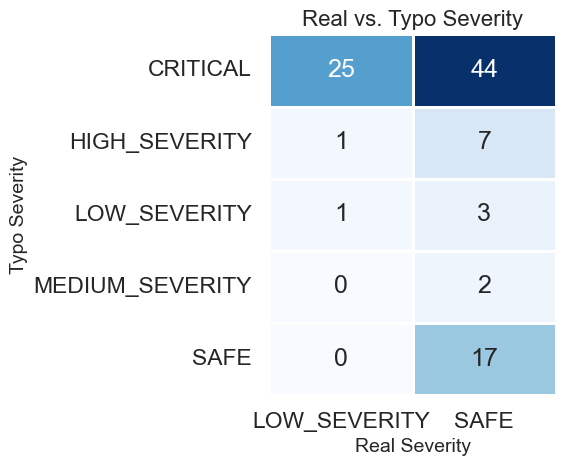

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -- After you've already created df_real and df_typo with a 'severity' column each --

# Merge real and typo DataFrames to get both severity labels in one row.
# We'll merge on 'id' from df_real and 'crate' from df_typo, 
# which should match if your earlier logic aligns them properly.
df_severity = pd.merge(
    df_real[['id', 'severity']], 
    df_typo[['crate', 'severity']], 
    left_on='id', 
    right_on='crate', 
    suffixes=('_real', '_typo')
)

# Create a crosstab: index = typo severity, columns = real severity.
# This ensures the x-axis is real severity, y-axis is typo severity.
ct = pd.crosstab(df_severity['severity_typo'], df_severity['severity_real'])

# Set a nice Seaborn theme.
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(6, 5))
sns.heatmap(
    ct,
    annot=True,       # show exact counts in each cell
    fmt="d",          # format as integers
    cmap="Blues",     # color palette
    cbar=False,       # turn off color bar if you just want the matrix
    linewidths=1,     # grid lines between cells
    linecolor='white' # color of the grid lines
)

plt.xlabel("Real Severity", fontsize=14)
plt.ylabel("Typo Severity", fontsize=14)
plt.title("Real vs. Typo Severity", fontsize=16)
plt.tight_layout()
plt.show()


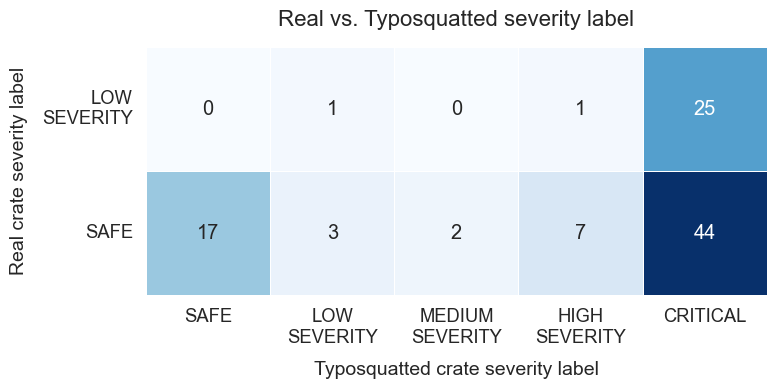

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Example Data Merge (Assumes df_real, df_typo already exist) ---
df_severity = pd.merge(
    df_real[['id', 'severity']], 
    df_typo[['crate', 'severity']], 
    left_on='id', 
    right_on='crate', 
    suffixes=('_real', '_typo')
)

# --- Define separate category orders for y (real severity) and x (typo severity) ---
# Y-axis: Just LOW_SEVERITY, SAFE (in that order)
cat_order_real = ["LOW_SEVERITY", "SAFE"]

# X-axis: Full order (adjust if you have more or fewer categories)
cat_order_typo = ["SAFE", "LOW_SEVERITY", "MEDIUM_SEVERITY", "HIGH_SEVERITY", "CRITICAL"]

# --- Convert columns to ordered categorical using the above orders ---
df_severity['severity_real'] = pd.Categorical(
    df_severity['severity_real'],
    categories=cat_order_real,
    ordered=True
)
df_severity['severity_typo'] = pd.Categorical(
    df_severity['severity_typo'],
    categories=cat_order_typo,
    ordered=True
)

# --- Create the crosstab: rows = real severity, columns = typo severity ---
ct = pd.crosstab(df_severity['severity_real'], df_severity['severity_typo'])

# --- Replace severity strings with multi-line labels if desired ---
label_map = {
    "LOW_SEVERITY": "LOW\nSEVERITY",
    "SAFE": "SAFE",
    "MEDIUM_SEVERITY": "MEDIUM\nSEVERITY",
    "HIGH_SEVERITY": "HIGH\nSEVERITY",
    "CRITICAL": "CRITICAL"
}

ct.index = ct.index.map(label_map)
ct.columns = ct.columns.map(label_map)

# --- Seaborn styling ---
sns.set_theme(style="white", context="talk")
sns.set(font_scale=1.2)

# --- Create figure ---
plt.figure(figsize=(8, 6))

# --- Heatmap without color bar ---
ax = sns.heatmap(
    ct,
    annot=True,       # Show exact counts
    fmt="d",          # Format as integers
    cmap="Blues",     # Blue color palette
    cbar=False,       # Remove color bar
    linewidths=0.5,
    linecolor='white',
    square=True
)

# --- Force tick labels to be horizontal ---
plt.xticks(rotation=0, ha='center')
plt.yticks(rotation=0, va='center')

# --- Axis labels and title ---
plt.xlabel("Typosquatted crate severity label", fontsize=14, labelpad=10)
plt.ylabel("Real crate severity label", fontsize=14, labelpad=10)
plt.title("Real vs. Typosquatted severity label", fontsize=16, pad=15)

# --- Tight layout so labels don’t get cut off ---
plt.tight_layout()
plt.savefig('/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq1/heat-3.pdf' , bbox_inches='tight')
plt.show()


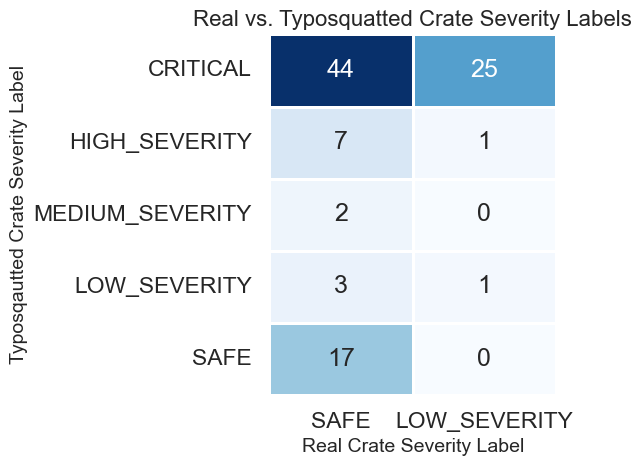

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -- After you've already created df_real and df_typo with a 'severity' column each --

# Merge real and typo DataFrames to get both severity labels in one row.
df_severity = pd.merge(
    df_real[['id', 'severity']], 
    df_typo[['crate', 'severity']], 
    left_on='id', 
    right_on='crate', 
    suffixes=('_real', '_typo')
)

# Create a crosstab: index = typo severity, columns = real severity.
ct = pd.crosstab(df_severity['severity_typo'], df_severity['severity_real'])

# Reorder the axes as requested:
x_order = ["SAFE", "LOW_SEVERITY"]
y_order = ["CRITICAL", "HIGH_SEVERITY", "MEDIUM_SEVERITY", "LOW_SEVERITY", "SAFE"]

ct = ct.reindex(index=y_order, columns=x_order, fill_value=0)

# Set a nice Seaborn theme.
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(6, 5))
sns.heatmap(
    ct,
    annot=True,       # show exact counts in each cell
    fmt="d",          # format as integers
    cmap="Blues",     # color palette
    cbar=False,       # turn off color bar if desired
    linewidths=1,     # grid lines between cells
    linecolor='white' # color of the grid lines
)

plt.xlabel("Real Crate Severity Label", fontsize=14)
plt.ylabel("Typosqautted Crate Severity Label", fontsize=14)
plt.title("Real vs. Typosquatted Crate Severity Labels", fontsize=16)
plt.tight_layout()
plt.savefig('/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq1/heat-3.pdf' , bbox_inches='tight')
plt.show()


In [67]:
# ---- Find names where real=LOW_SEVERITY (x) and typo=SAFE (y) ----
pairs = (
    df_real[['id', 'crate', 'severity']]
      .rename(columns={'severity': 'severity_real'})
      .merge(
          df_typo[['crate', 'typo', 'severity']].rename(columns={'severity': 'severity_typo'}),
          on='crate',
          how='inner'
      )
)

sel = pairs[(pairs['severity_real'] == 'LOW_SEVERITY') & (pairs['severity_typo'] == 'SAFE')]

print("Crates where real=LOW_SEVERITY (x) and typo=SAFE (y):")
for _, row in sel.iterrows():
    # row['crate'] is the real crate name; row['typo'] is the typo filename
    print(f"- {row['crate']}  (typo file: {row['typo']})")



Crates where real=LOW_SEVERITY (x) and typo=SAFE (y):


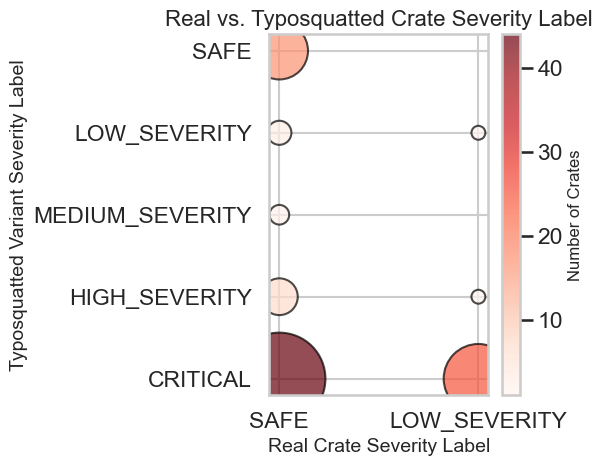

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume df_real and df_typo have been created and contain a 'severity' column ---

# Merge real and typo DataFrames to get both severity labels in one row.
df_severity = pd.merge(
    df_real[['id', 'severity']], 
    df_typo[['crate', 'severity']], 
    left_on='id', 
    right_on='crate', 
    suffixes=('_real', '_typo')
)

# Define the desired orders:
x_order = ["SAFE", "LOW_SEVERITY"]   # Real severity order (x-axis)
y_order = ["CRITICAL", "HIGH_SEVERITY", "MEDIUM_SEVERITY", "LOW_SEVERITY", "SAFE"]  # Typo severity order (y-axis)

# Map severity labels to numeric codes.
severity_mapping_real = {label: i for i, label in enumerate(x_order)}
severity_mapping_typo = {label: i for i, label in enumerate(y_order)}

# Create numeric codes in the merged DataFrame.
df_severity["real_code"] = df_severity["severity_real"].map(severity_mapping_real)
df_severity["typo_code"] = df_severity["severity_typo"].map(severity_mapping_typo)

# Group by the numeric codes and count the number of crates in each combination.
density = df_severity.groupby(["real_code", "typo_code"]).size().reset_index(name="count")

# Set a Seaborn theme.
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(6, 5))
# Create a scatter plot where marker size and color reflect the density.
scatter = plt.scatter(
    density["real_code"], 
    density["typo_code"], 
    s=density["count"] * 100,  # scale marker sizes by the count (adjust multiplier as needed)
    c=density["count"],
    cmap="Reds",
    alpha=0.7,
    edgecolors="black"
)
plt.xlabel("Real Crate Severity Label", fontsize=14)
plt.ylabel("Typosquatted Variant Severity Label", fontsize=14)
plt.title("Real vs. Typosquatted Crate Severity Label", fontsize=16)
plt.xticks(range(len(x_order)), x_order)
plt.yticks(range(len(y_order)), y_order)
cbar = plt.colorbar(scatter)
cbar.set_label("Number of Crates", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq1/density-3.pdf' , bbox_inches='tight')
plt.show()


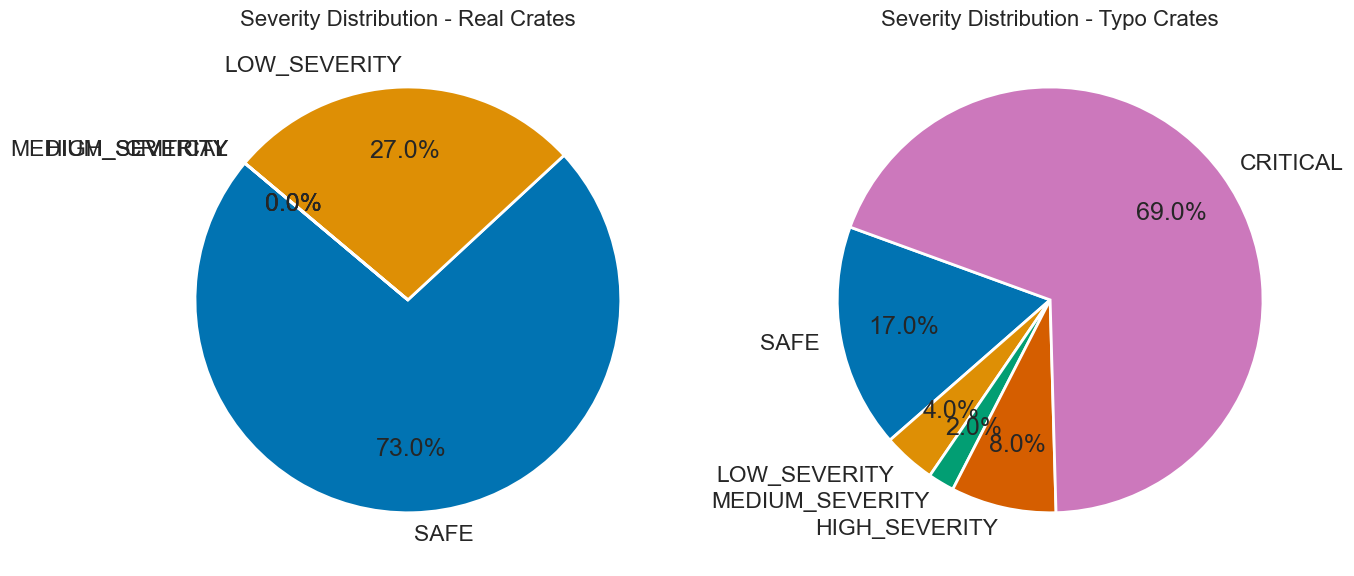

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# Example severity order (adjust as needed)
# ----------------------------------------------------
severity_order = [
    "SAFE",
    "LOW_SEVERITY",
    "MEDIUM_SEVERITY",
    "HIGH_SEVERITY",
    "CRITICAL"
]

# ----------------------------------------------------
# 1. Define a color palette and map each severity to a consistent color
#    Using the color-blind-friendly palette from Seaborn
# ----------------------------------------------------
palette = sns.color_palette("colorblind", n_colors=len(severity_order))
severity_colors = dict(zip(severity_order, palette))

# ----------------------------------------------------
# 2. Prepare your data (value_counts) for each chart
#    We assume df_real and df_typo each have a column 'severity'.
#    Reindex so that every severity in severity_order appears, even if count=0.
# ----------------------------------------------------
real_severity_counts = df_real['severity'].value_counts().reindex(severity_order, fill_value=0)
typo_severity_counts = df_typo['severity'].value_counts().reindex(severity_order, fill_value=0)

# Convert to lists for plotting
labels_real = real_severity_counts.index.tolist()
counts_real = real_severity_counts.values
colors_real = [severity_colors[label] for label in labels_real]

labels_typo = typo_severity_counts.index.tolist()
counts_typo = typo_severity_counts.values
colors_typo = [severity_colors[label] for label in labels_typo]

# ----------------------------------------------------
# 3. Create the figure and draw side-by-side pie charts
# ----------------------------------------------------
sns.set_theme(style="white", context="talk")  # or "whitegrid", if you prefer

plt.figure(figsize=(14, 7))

# ------------------ Pie Chart: Real ------------------
plt.subplot(1, 2, 1)
plt.pie(
    counts_real,
    labels=labels_real,
    colors=colors_real,
    autopct='%1.1f%%',
    startangle=140,
    labeldistance=1.1,    # distance of labels from center
    pctdistance=0.7,      # distance of percent labels from center
    wedgeprops=dict(edgecolor='white', linewidth=2)
)
plt.title("Severity Distribution - Real Crates", fontsize=16)

# ------------------ Pie Chart: Typo ------------------
plt.subplot(1, 2, 2)
plt.pie(
    counts_typo,
    labels=labels_typo,
    colors=colors_typo,
    autopct='%1.1f%%',
    startangle=160,       # slight difference can reduce overlap
    labeldistance=1.1,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor='white', linewidth=2)
)
plt.title("Severity Distribution - Typo Crates", fontsize=16)

plt.tight_layout()
plt.show()


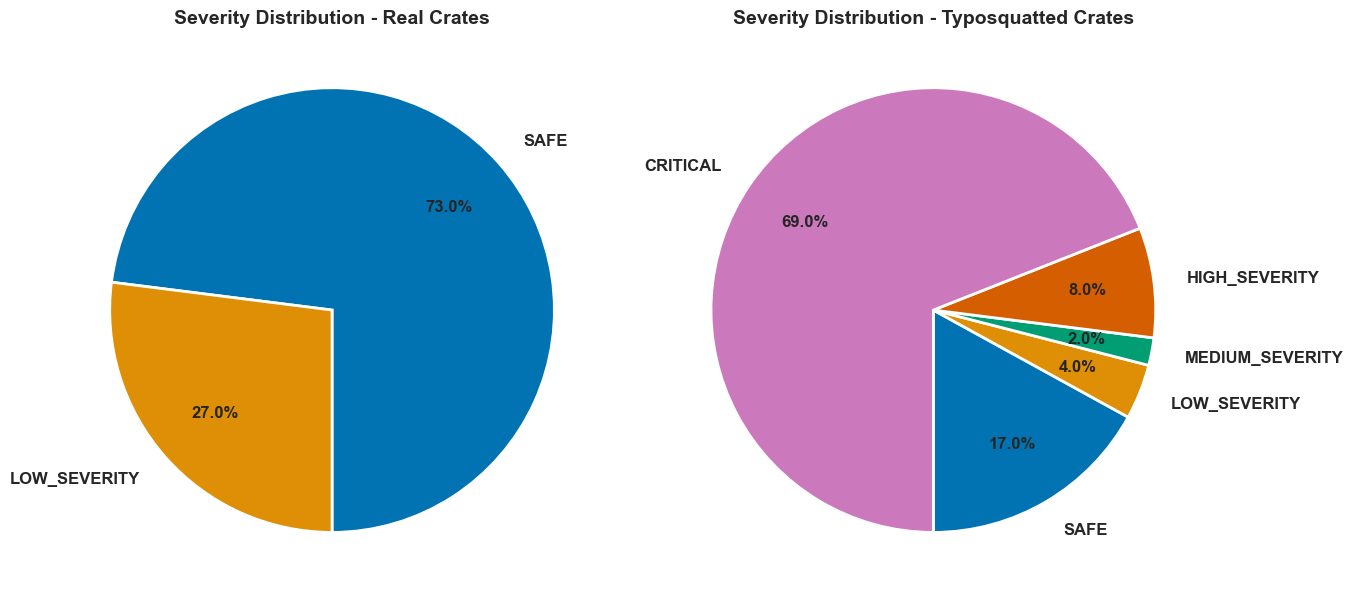

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define a severity order so "SAFE" is first, then others.
severity_list = ["SAFE", "LOW_SEVERITY", "MEDIUM_SEVERITY", "HIGH_SEVERITY", "CRITICAL"]

# 2. Create a color-blind-friendly palette and map each severity to a color.
palette = sns.color_palette("colorblind", n_colors=len(severity_list))
severity_colors = dict(zip(severity_list, palette))

# 3. Build severity counts for Real and Typo crates.
#    Reindex to get a consistent order, fill zeros, then drop them if you want them hidden.
real_counts = df_real['severity'].value_counts()
real_counts = real_counts.reindex(severity_list, fill_value=0)
real_counts = real_counts[real_counts > 0]  # drop zero severities

typo_counts = df_typo['severity'].value_counts()
typo_counts = typo_counts.reindex(severity_list, fill_value=0)
typo_counts = typo_counts[typo_counts > 0]

# Convert to lists for plotting
labels_real = real_counts.index.tolist()
counts_real = real_counts.values
colors_real = [severity_colors[label] for label in labels_real]

labels_typo = typo_counts.index.tolist()
counts_typo = typo_counts.values
colors_typo = [severity_colors[label] for label in labels_typo]

# 4. Create side-by-side pie charts, ensuring "SAFE" (if present) starts at the bottom.
sns.set_theme(style="white", context="talk")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Define text properties with bold font for both labels and percentages.
text_props = dict(fontsize=12, fontweight="bold")

# -- Pie Chart: Real Crates --
wedges1, texts1, autotexts1 = ax1.pie(
    counts_real,
    labels=labels_real,
    colors=colors_real,
    autopct='%1.1f%%',
    startangle=270,                # rotate so first wedge starts at bottom
    labeldistance=1.15,            # distance of labels from center
    pctdistance=0.7,               # distance of percentage text from center
    wedgeprops=dict(edgecolor='white', linewidth=2),
    textprops=text_props
)
ax1.set_title("Severity Distribution - Real Crates", fontsize=14, fontweight="bold")

# -- Pie Chart: Typo Crates --
wedges2, texts2, autotexts2 = ax2.pie(
    counts_typo,
    labels=labels_typo,
    colors=colors_typo,
    autopct='%1.1f%%',
    startangle=270,                # same orientation as the first pie
    labeldistance=1.15,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor='white', linewidth=2),
    textprops=text_props
)
ax2.set_title("Severity Distribution - Typosquatted Crates", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig('/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq1/pie-3.pdf' , bbox_inches='tight')
plt.show()


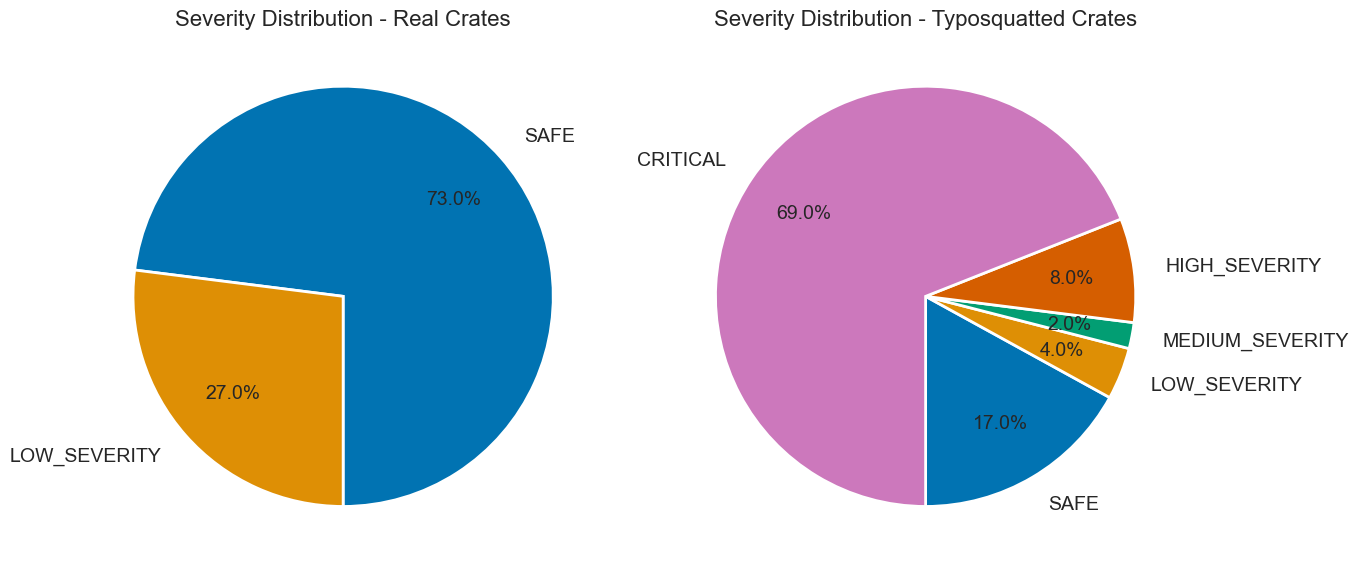

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define a severity order so "SAFE" is first, then others.
severity_list = ["SAFE", "LOW_SEVERITY", "MEDIUM_SEVERITY", "HIGH_SEVERITY", "CRITICAL"]

# 2. Create a color-blind-friendly palette and map each severity to a color.
palette = sns.color_palette("colorblind", n_colors=len(severity_list))
severity_colors = dict(zip(severity_list, palette))

# 3. Build severity counts for Real and Typo crates.
real_counts = df_real['severity'].value_counts()
real_counts = real_counts.reindex(severity_list, fill_value=0)
real_counts = real_counts[real_counts > 0]

typo_counts = df_typo['severity'].value_counts()
typo_counts = typo_counts.reindex(severity_list, fill_value=0)
typo_counts = typo_counts[typo_counts > 0]

labels_real = real_counts.index.tolist()
counts_real = real_counts.values
colors_real = [severity_colors[label] for label in labels_real]

labels_typo = typo_counts.index.tolist()
counts_typo = typo_counts.values
colors_typo = [severity_colors[label] for label in labels_typo]

# 4. Create side-by-side pie charts, ensuring "SAFE" (if present) starts at the bottom.
sns.set_theme(style="white", context="talk")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# -- Pie Chart: Real Crates --
wedges1, texts1, autotexts1 = ax1.pie(
    counts_real,
    labels=labels_real,
    colors=colors_real,
    autopct='%1.1f%%',
    startangle=270,
    labeldistance=1.15,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor='white', linewidth=2),
    textprops=dict(fontsize=14)    # larger label font
)
ax1.set_title("Severity Distribution - Real Crates", fontsize=16)

# Increase autopct font size (the percentage text) if needed
for t in autotexts1:
    t.set_fontsize(14)

# -- Pie Chart: Typo Crates --
wedges2, texts2, autotexts2 = ax2.pie(
    counts_typo,
    labels=labels_typo,
    colors=colors_typo,
    autopct='%1.1f%%',
    startangle=270,
    labeldistance=1.15,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor='white', linewidth=2),
    textprops=dict(fontsize=14)
)
ax2.set_title("Severity Distribution - Typosquatted Crates", fontsize=16)

for t in autotexts2:
    t.set_fontsize(14)

plt.tight_layout()

plt.savefig('/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq1/pie-3.pdf', bbox_inches='tight')
plt.show()


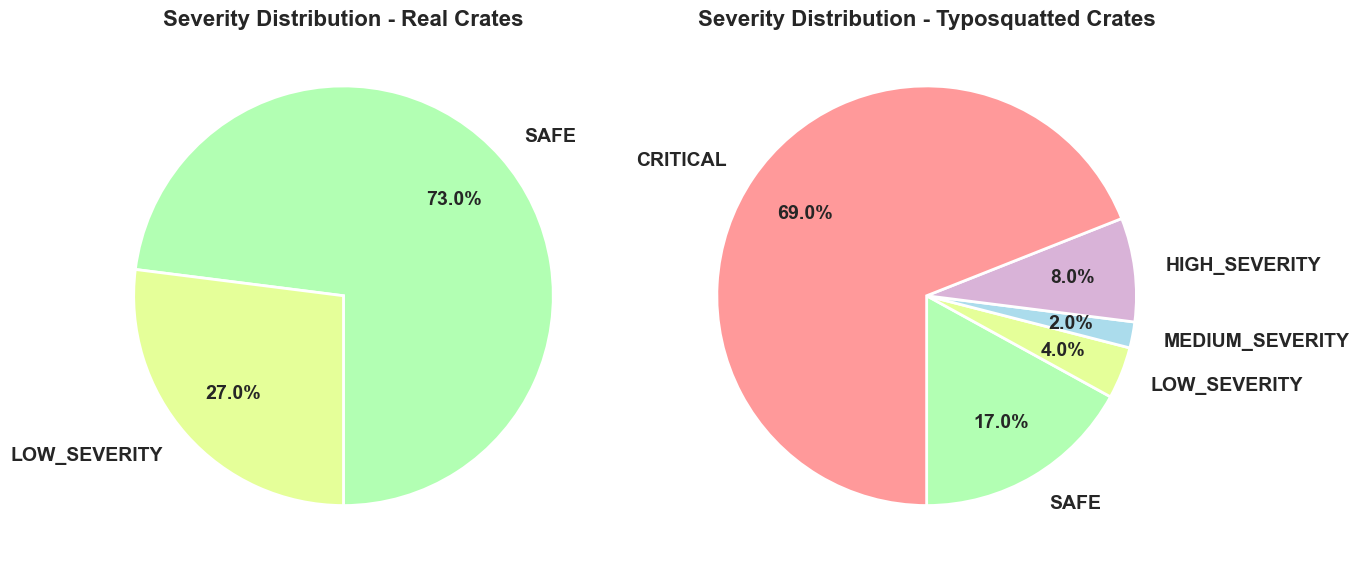

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define a severity order so that "SAFE" is first, then others.
severity_list = ["SAFE", "LOW_SEVERITY", "MEDIUM_SEVERITY", "HIGH_SEVERITY", "CRITICAL"]

# 2. Define a custom color mapping matching the TikZ colors.
severity_colors = {
    "SAFE":          "#b2ffb3",  # green!30!white, if "green"=(0,1,0)
    "LOW_SEVERITY":  "#e5ff99",  # lime!40!white
    "MEDIUM_SEVERITY": "#abdcec",# cyan!30!white
    "HIGH_SEVERITY": "#d9b3d8",  # violet!30!white
    "CRITICAL":      "#ff999a"   # red!40!white
}

# 3. Build severity counts for Real and Typo crates.
real_counts = df_real['severity'].value_counts()
real_counts = real_counts.reindex(severity_list, fill_value=0)
real_counts = real_counts[real_counts > 0]

typo_counts = df_typo['severity'].value_counts()
typo_counts = typo_counts.reindex(severity_list, fill_value=0)
typo_counts = typo_counts[typo_counts > 0]

labels_real = real_counts.index.tolist()
counts_real = real_counts.values
colors_real = [severity_colors[label] for label in labels_real]

labels_typo = typo_counts.index.tolist()
counts_typo = typo_counts.values
colors_typo = [severity_colors[label] for label in labels_typo]

# 4. Create side-by-side pie charts, ensuring "SAFE" (if present) starts at the bottom.
sns.set_theme(style="white", context="talk")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Common text properties with bold labels:
text_properties = dict(fontsize=14, fontweight='bold')

# -- Pie Chart: Real Crates --
wedges1, texts1, autotexts1 = ax1.pie(
    counts_real,
    labels=labels_real,
    colors=colors_real,
    autopct='%1.1f%%',
    startangle=270,  # rotates chart so that if "SAFE" is present, it appears at the bottom.
    labeldistance=1.15,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor='white', linewidth=2),
    textprops=text_properties
)
ax1.set_title("Severity Distribution - Real Crates", fontsize=16, fontweight='bold')
for t in autotexts1:
    t.set_fontsize(14)
    t.set_fontweight('bold')

# -- Pie Chart: Typo Crates --
wedges2, texts2, autotexts2 = ax2.pie(
    counts_typo,
    labels=labels_typo,
    colors=colors_typo,
    autopct='%1.1f%%',
    startangle=270,
    labeldistance=1.15,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor='white', linewidth=2),
    textprops=text_properties
)
ax2.set_title("Severity Distribution - Typosquatted Crates", fontsize=16, fontweight='bold')
for t in autotexts2:
    t.set_fontsize(14)
    t.set_fontweight('bold')

plt.tight_layout()
plt.savefig('/Users/hassnain/Desktop/pie.pdf', bbox_inches='tight')
plt.show()


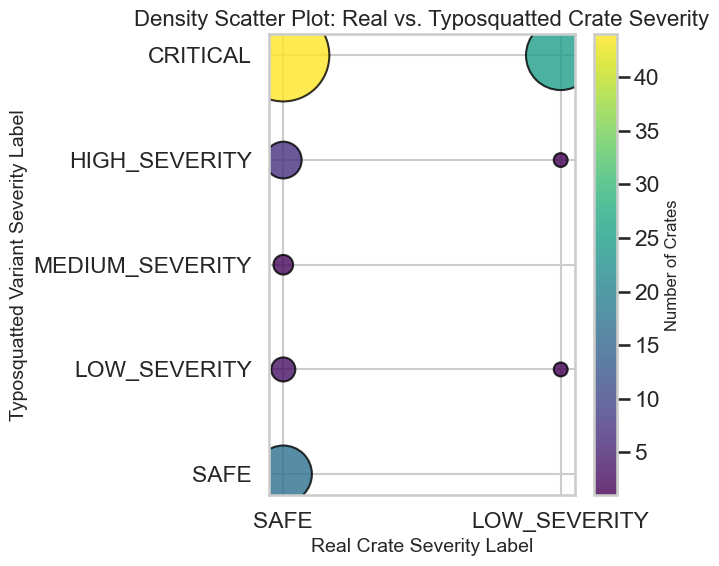

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume df_real and df_typo have been created and contain a 'severity' column ---

# Merge real and typo DataFrames to get both severity labels in one row.
df_severity = pd.merge(
    df_real[['id', 'severity']], 
    df_typo[['crate', 'severity']], 
    left_on='id', 
    right_on='crate', 
    suffixes=('_real', '_typo')
)

# Define the desired orders:
x_order = ["SAFE", "LOW_SEVERITY"]   # Real severity order (x-axis)
y_order = ["SAFE", "LOW_SEVERITY", "MEDIUM_SEVERITY", "HIGH_SEVERITY", "CRITICAL"]  # Typo severity order (y-axis)

# Map severity labels to numeric codes.
severity_mapping_real = {label: i for i, label in enumerate(x_order)}
severity_mapping_typo = {label: i for i, label in enumerate(y_order)}

# Create numeric codes in the merged DataFrame.
df_severity["real_code"] = df_severity["severity_real"].map(severity_mapping_real)
df_severity["typo_code"] = df_severity["severity_typo"].map(severity_mapping_typo)

# Group by the numeric codes and count the number of crates in each combination.
density = df_severity.groupby(["real_code", "typo_code"]).size().reset_index(name="count")

# Set a Seaborn theme.
sns.set_theme(style="whitegrid", context="talk")

plt.figure(figsize=(7, 6))
# Create a scatter plot where marker size and color reflect the density.
scatter = plt.scatter(
    density["real_code"], 
    density["typo_code"], 
    s=density["count"] * 100,  # scale marker sizes by the count (adjust multiplier as needed)
    c=density["count"],
    cmap="viridis",            # use a color-blind friendly continuous colormap
    alpha=0.8,
    edgecolors="black"
)
plt.xlabel("Real Crate Severity Label", fontsize=14)
plt.ylabel("Typosquatted Variant Severity Label", fontsize=14)
plt.title("Density Scatter Plot: Real vs. Typosquatted Crate Severity", fontsize=16)
plt.xticks(range(len(x_order)), x_order)
plt.yticks(range(len(y_order)), y_order)
cbar = plt.colorbar(scatter)
cbar.set_label("Number of Crates", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/hassnain/Desktop/rhs-paper/src/img/evaluation/rq1/density-3.pdf' , bbox_inches='tight')
plt.show()


In [74]:
# Filter for crates with LOW_SEVERITY in real and SAFE in typo evaluations
low_real_safe_typo = df_severity[
    (df_severity['severity_real'] == "LOW_SEVERITY") & 
    (df_severity['severity_typo'] == "SAFE")
]

# Print the names of the crates (assuming the crate name is in the 'id' column)
print("Crates with LOW_SEVERITY in real and SAFE in typo evaluations:")
print(low_real_safe_typo['id'].tolist())


Crates with LOW_SEVERITY in real and SAFE in typo evaluations:
[]


In [75]:
# Filter for crates with LOW_SEVERITY in real and SAFE in typo evaluations
low_real_safe_typo = df_severity[
    (df_severity['severity_real'] == "LOW_SEVERITY") & 
    (df_severity['severity_typo'] == "SAFE")
]

# Extract the typosquatted names
typosquatted_names = low_real_safe_typo['crate'].tolist()

print("Typosquatted names for crates with LOW_SEVERITY in real and SAFE in typo evaluations:")
print(typosquatted_names)


Typosquatted names for crates with LOW_SEVERITY in real and SAFE in typo evaluations:
[]


In [76]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


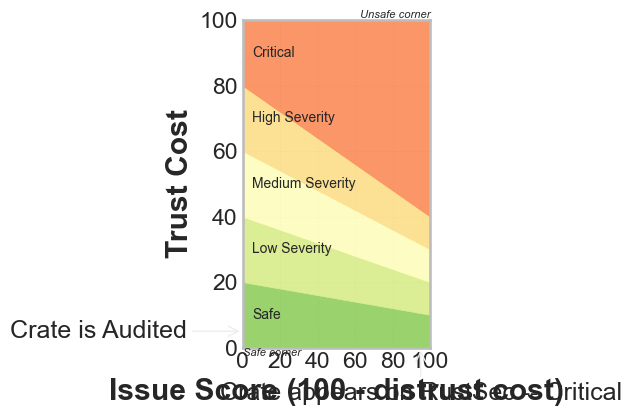

In [77]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import numpy as np

# OPTIONAL: Use LaTeX for text (requires a working LaTeX setup)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.size": 11
# })

# Use a clean style with subtle grid lines
plt.style.use("bmh")

# Figure and axis
fig, ax = plt.subplots(figsize=(6.5, 4.5))

# Define x-range and boundary lines for each region
x = np.array([0, 100])
y0 = np.array([0,   0])   # bottom
y1 = np.array([20, 10])   # Safe/Low boundary
y2 = np.array([40, 20])   # Low/Medium boundary
y3 = np.array([60, 30])   # Medium/High boundary
y4 = np.array([80, 40])   # High/Critical boundary
y5 = np.array([100, 100]) # top

# Define a pleasant color palette (5 colors from greenish to reddish)
colors = [
    "#91cf60",  # Safe (light green)
    "#d9ef8b",  # Low
    "#ffffbf",  # Medium
    "#fee08b",  # High
    "#fc8d59"   # Critical (orange-red)
]

# Fill each region (bottom to top)
ax.fill_between(x, y0, y1, color=colors[0], alpha=0.9)
ax.fill_between(x, y1, y2, color=colors[1], alpha=0.9)
ax.fill_between(x, y2, y3, color=colors[2], alpha=0.9)
ax.fill_between(x, y3, y4, color=colors[3], alpha=0.9)
ax.fill_between(x, y4, y5, color=colors[4], alpha=0.9)

# Region labels (place them at x=5, y ~ midpoint of each band)
ax.text(5, 10,  "Safe",            fontsize=10, va="center", ha="left")
ax.text(5, 30,  "Low Severity",    fontsize=10, va="center", ha="left")
ax.text(5, 50,  "Medium Severity", fontsize=10, va="center", ha="left")
ax.text(5, 70,  "High Severity",   fontsize=10, va="center", ha="left")
ax.text(5, 90,  "Critical",        fontsize=10, va="center", ha="left")

# Axis labels
ax.set_xlabel("Issue Score (100 - distrust cost)", fontweight="bold")
ax.set_ylabel("Trust Cost", fontweight="bold")

# Axis ticks
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_yticks([0, 20, 40, 60, 80, 100])

# Annotations:
# 1) "Crate is Audited" near (0,5)
ax.annotate(
    "Crate is Audited",
    xy=(0, 5), 
    xytext=(-40, 0),   # shift 40 points left
    textcoords="offset points",
    ha="right",
    va="center",
    arrowprops=dict(arrowstyle="->", lw=1.0)
)

# 2) "Crate appears on RustSec -- Critical" near (95,0)
ax.annotate(
    "Crate appears on RustSec -- Critical",
    xy=(95, 0),
    xytext=(0, -25),   # shift 25 points downward
    textcoords="offset points",
    ha="center",
    va="top",
    arrowprops=dict(arrowstyle="->", lw=1.0)
)

# Optional corner labels (smaller, italic)
ax.text(0,   0,   "Safe corner",   fontsize=8, style="italic", va="top",    ha="left")
ax.text(100, 100, "Unsafe corner", fontsize=8, style="italic", va="bottom", ha="right")

plt.tight_layout()

# Save as PDF (vector)
# plt.savefig("trust_vs_issue_spectral.pdf", dpi=300)
plt.show()
